<a href="https://colab.research.google.com/github/Cp557/AstroML-Galaxy-Analysis/blob/main/galaxy_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Galaxy Morphological Classification

This script implements a deep learning model to classify galaxies into
three morphological types: merger, elliptical, and spiral. It uses
various features including color indices, shape parameters, and predicted
redshift from a separate regression model.

Key Features:
- Data loading and preprocessing of galaxy catalogue data
- Integration of predicted redshift from a pre-trained model
- Exploratory data analysis
- Implementation of a neural network using TensorFlow/Keras
- Model training with early stopping and regularization
- Model evaluation including confusion matrix and ROC AUC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from joblib import load

In [ ]:
galaxy_catalogue_path = '/content/drive/MyDrive/Coding/astronomy_ML/galaxy_catalogue.npy' #path to galaxy catalogue data'
galaxy_data = np.load(galaxy_catalogue_path)
data = pd.DataFrame(galaxy_data)
print(data.columns)

Index(['u-g', 'g-r', 'r-i', 'i-z', 'ecc', 'm4_u', 'm4_g', 'm4_r', 'm4_i',
       'm4_z', 'petroR50_u', 'petroR50_r', 'petroR50_z', 'petroR90_u',
       'petroR90_r', 'petroR90_z', 'class'],
      dtype='object')


In [ ]:
# Calculating concentration with ratio of radii containing 50 and 90%
data['petro_u'] = data['petroR50_u'] / data['petroR90_u']
data['petro_r'] = data['petroR50_r'] / data['petroR90_r']
data['petro_z'] = data['petroR50_z'] / data['petroR90_z']

data = data.drop(columns=['petroR50_u', 'petroR90_u', 'petroR50_r', 'petroR90_r', 'petroR50_z', 'petroR90_z'])

In [ ]:
# Loading redshift regression model
redshift_model = load('/content/drive/MyDrive/Coding/astronomy_ML/redshift_model.joblib')

In [ ]:
color_indices = data[['u-g', 'g-r', 'r-i', 'i-z']]

# Predict redshift
predicted_redshift = redshift_model.predict(color_indices)

# Add predicted redshift to dataframe
data['redshift'] = predicted_redshift


In [ ]:
data  = data.dropna()
print('galaxy df:')
print(data.info())

galaxy df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   u-g       780 non-null    float64
 1   g-r       780 non-null    float64
 2   r-i       780 non-null    float64
 3   i-z       780 non-null    float64
 4   ecc       780 non-null    float64
 5   m4_u      780 non-null    float64
 6   m4_g      780 non-null    float64
 7   m4_r      780 non-null    float64
 8   m4_i      780 non-null    float64
 9   m4_z      780 non-null    float64
 10  class     780 non-null    object 
 11  petro_u   780 non-null    float64
 12  petro_r   780 non-null    float64
 13  petro_z   780 non-null    float64
 14  redshift  780 non-null    float32
dtypes: float32(1), float64(13), object(1)
memory usage: 88.5+ KB
None


Column Descriptions:

u-g, g-r, r-i, i-z: Color indices, representing differences between magnitudes in different filters. These indices provide information about the color and, therefore, the properties of the galaxies.

ecc: Eccentricity approximates the shape of the galaxy by fitting an ellipse to its profile. Eccentricity is the ratio of the lengths of the semi-major axis to the semi-minor axis, with values ranging from 0 (a perfect circle) to 1 (a line).

m4_u, m4_g, m4_r, m4_i, m4_z: Adaptive moments, which are measured quantities used to describe the shape of a galaxy in different filters (u, g, r, i, z). These moments give insight into the galaxy's structure.

petro_u, petro_r, petro_z: Petrosian radii in different filters (u, r, z), measuring the concentration of light in a galaxy. The concentration metric indicates the proportion of a galaxy's total light emitted within a specific radius.

redshift: The redshift measures how much the light from a galaxy has been stretched as it moves away from us, shifting towards longer (redder) wavelengths. This shift is an indication of the galaxy's velocity relative to us, which is due to the expansion of the universe.

Classes:


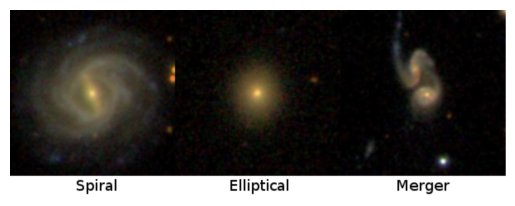

In [ ]:
img = mpimg.imread('/content/drive/MyDrive/Coding/astronomy_ML/galaxies.png')
plt.imshow(img)
plt.axis('off')
print('Classes:')
plt.show()

In [ ]:
X = data[['u-g', 'g-r', 'r-i', 'i-z', 'ecc', 'm4_u', 'm4_g', 'm4_r', 'm4_i', 'm4_z', 'petro_u', 'petro_r', 'petro_z', 'redshift']]
y = data['class']

In [ ]:
# Convert strings
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# Cconvert integers to one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
y_encoded = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42)

In [ ]:
model = keras.Sequential([
    keras.layers.Input(shape=(X.shape[1],)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose = 0, validation_split = 0.2, callbacks=[early_stopping])

In [ ]:
best_train_accuracy = max(history.history['accuracy'])
best_train_loss = min(history.history['loss'])
best_train_accuracy_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_train_loss_epoch = history.history['loss'].index(min(history.history['loss'])) + 1

In [ ]:
best_val_accuracy = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])
best_val_accuracy_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_loss_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1

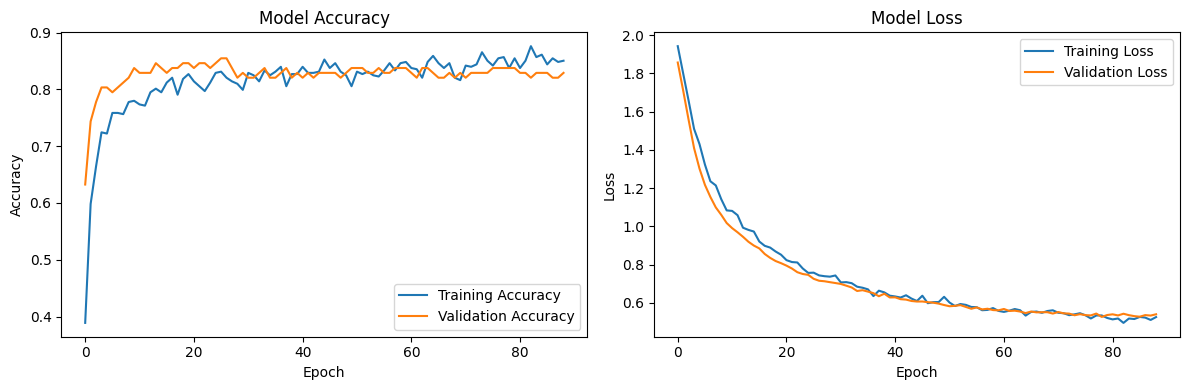

Best training accuracy (0.8761) was achieved at epoch 83
Best training loss (0.4959) was achieved at epoch 83
Best validation accuracy (0.8547) was achieved at epoch 26
Best validation loss (0.5270) was achieved at epoch 79


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best training accuracy ({best_train_accuracy:.4f}) was achieved at epoch {best_train_accuracy_epoch}")
print(f"Best training loss ({best_train_loss:.4f}) was achieved at epoch {best_train_loss_epoch}")
print(f"Best validation accuracy ({best_val_accuracy:.4f}) was achieved at epoch {best_val_accuracy_epoch}")
print(f"Best validation loss ({best_val_loss:.4f}) was achieved at epoch {best_val_loss_epoch}")

In [ ]:
def model_report(model, X_test, y_test, class_names):
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate various metrics
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    # Classification report
    class_report = classification_report(y_true, y_pred_classes, target_names=class_names)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # ROC AUC score (for multi-class, we use one-vs-rest)
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')

    # Print the report
    print("Model Performance Report")
    print("========================")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"\nROC AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Model Performance Report
Test Loss: 0.5706
Test Accuracy: 0.8564

ROC AUC Score: 0.9369

Classification Report:
              precision    recall  f1-score   support

      merger       0.88      0.99      0.93        70
  elliptical       0.82      0.72      0.77        64
      spiral       0.85      0.85      0.85        61

    accuracy                           0.86       195
   macro avg       0.85      0.85      0.85       195
weighted avg       0.85      0.86      0.85       195



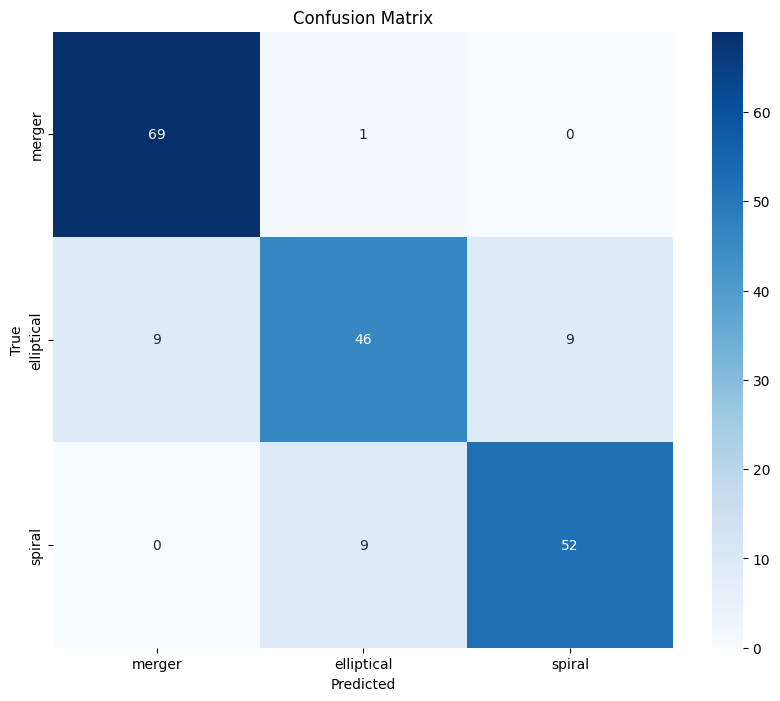

In [ ]:
class_names = ['merger', 'elliptical', 'spiral']
model_report(model, X_test, y_test, class_names)